In [22]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, \
    RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_pickle('./all_data.pkl')

NUM_LABEL_COLS = 13
NUM_COMPONENTS = 26
RANDOM_SEED = 0

#####################################
#####################################

df_filtered = df
df_filtered.shape

# exclude records we want to exclude
df_filtered = df_filtered[df_filtered['trmp'] == '0']
df_filtered = df_filtered[df_filtered['trmb'] == '0']
df_filtered = df_filtered[df_filtered['otrb'] == '0']
df_filtered = df_filtered[df_filtered['ext'] == '0']
df_filtered = df_filtered[df_filtered['excl'] == '0']
print('df filt shape: ', df_filtered.shape)

# we are keeping sop, alt, tenr, tora, bari, clrt, other = 7
                                                                        # off by one?
num_x_cols = df_filtered.shape[1] - NUM_LABEL_COLS                      # - 1 
print('num_x_cols:', num_x_cols)

data = df_filtered.iloc[:, 1:num_x_cols].to_numpy() 
# ^ These are the features

scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

# Create target column
combined = df_filtered[['sop']].to_numpy() + \
    df_filtered[['alto']].to_numpy() + \
    df_filtered[['tenr']].to_numpy() + \
    df_filtered[['tora']].to_numpy() + \
    df_filtered[['bari']].to_numpy()
    
combined = combined.astype('int')
combined[combined > 0] = 1
df_filtered['sax'] = combined

target = df_filtered[['sax']].to_numpy().ravel()  # << This is the label

print(data.shape)
print(target.shape)

#####################################
#####################################

pca = PCA(n_components=NUM_COMPONENTS)
pca.fit(data)
PCA(n_components=29)

d = pca.transform(data)

#####################################
#####################################

x_train, x_test, y_train, y_test = \
     train_test_split(d, target, test_size=0.20, random_state=0)

df filt shape:  (7657, 10790)
num_x_cols: 10777
(7657, 10776)
(7657,)


In [16]:
def evaluate_classifer(clf, x_train, y_train, x_test, y_test):
    
    # train model
    clf_trained = clf.fit(x_train,y_train)

#     print(x_train.shape)
#     print(x_test.shape)
#     print(y_train.shape)
#     print(y_test.shape)
    
    # test model
    y_predict = clf.predict(x_test)
    # score model
    clf_score = clf.score(x_test, y_test)
    
    print(classification_report(y_test, y_predict))
    
    confus_mat = pd.DataFrame(confusion_matrix(y_test, y_predict))
    
    c_matrix = confusion_matrix(y_test, y_predict)
    idx = cols = [0, 1]
    cf_mat_pd = pd.DataFrame(c_matrix, index=idx, columns=cols)
    print(cf_mat_pd)
#     plt.imshow(confus_mat)
    
    return {'clf_trained': clf_trained,\
            'x_train': x_train, 'x_test': x_test,\
            'y_train': y_train, 'y_test': y_test,\
            'y_predict': y_predict,\
            'clf_score':clf_score,\
            'confus_mat':confus_mat}
    
def show_confus(eval_clf):
    plt.imshow(eval_clf['confus_mat'])
    plt.xlabel('predicted class')
    plt.ylabel('actual class')
    plt.title('confusion matrix')

In [17]:
clf_SVM_poly = SVC(kernel = 'poly')
eval_SVM_poly = evaluate_classifer(clf_SVM_poly, x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.83      0.60      0.70       614
           1       0.78      0.92      0.84       918

    accuracy                           0.79      1532
   macro avg       0.80      0.76      0.77      1532
weighted avg       0.80      0.79      0.78      1532

     0    1
0  369  245
1   74  844


In [19]:
clf_SVM_rbf = SVC(kernel='rbf')
eval_SVM_rbf = evaluate_classifer(clf_SVM_rbf, x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       614
           1       0.86      0.90      0.88       918

    accuracy                           0.85      1532
   macro avg       0.85      0.84      0.85      1532
weighted avg       0.85      0.85      0.85      1532

     0    1
0  481  133
1   90  828


In [20]:
clf_SVM_linear = SVC(kernel='linear')
eval_SVM_linear = evaluate_classifer(clf_SVM_linear, x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.72      0.64      0.68       614
           1       0.77      0.84      0.80       918

    accuracy                           0.76      1532
   macro avg       0.75      0.74      0.74      1532
weighted avg       0.75      0.76      0.75      1532

     0    1
0  390  224
1  151  767


In [23]:
clf_forest_n10 = RandomForestClassifier(n_estimators=10)
eval_forest_n10 = evaluate_classifer(clf_forest_n10, x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       614
           1       0.83      0.82      0.82       918

    accuracy                           0.79      1532
   macro avg       0.78      0.79      0.78      1532
weighted avg       0.79      0.79      0.79      1532

     0    1
0  463  151
1  168  750


(49,)
(49, 2)
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       614
           1       0.76      0.76      0.76       918

    accuracy                           0.71      1532
   macro avg       0.70      0.70      0.70      1532
weighted avg       0.71      0.71      0.71      1532

     0    1
0  391  223
1  223  695
              precision    recall  f1-score   support

           0       0.57      0.84      0.68       614
           1       0.84      0.57      0.68       918

    accuracy                           0.68      1532
   macro avg       0.70      0.70      0.68      1532
weighted avg       0.73      0.68      0.68      1532

     0    1
0  513  101
1  392  526
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       614
           1       0.77      0.78      0.78       918

    accuracy                           0.73      1532
   macro avg       0.72      0.72      0.7

              precision    recall  f1-score   support

           0       0.77      0.73      0.75       614
           1       0.83      0.86      0.84       918

    accuracy                           0.81      1532
   macro avg       0.80      0.79      0.80      1532
weighted avg       0.80      0.81      0.81      1532

     0    1
0  449  165
1  132  786
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       614
           1       0.83      0.88      0.85       918

    accuracy                           0.81      1532
   macro avg       0.81      0.80      0.80      1532
weighted avg       0.81      0.81      0.81      1532

     0    1
0  444  170
1  114  804
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       614
           1       0.83      0.86      0.84       918

    accuracy                           0.81      1532
   macro avg       0.80      0.79      0.80      1532
we

              precision    recall  f1-score   support

           0       0.81      0.73      0.77       614
           1       0.83      0.89      0.86       918

    accuracy                           0.82      1532
   macro avg       0.82      0.81      0.81      1532
weighted avg       0.82      0.82      0.82      1532

     0    1
0  446  168
1  105  813
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       614
           1       0.83      0.89      0.86       918

    accuracy                           0.82      1532
   macro avg       0.82      0.81      0.81      1532
weighted avg       0.82      0.82      0.82      1532

     0    1
0  446  168
1  104  814
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       614
           1       0.82      0.90      0.86       918

    accuracy                           0.82      1532
   macro avg       0.82      0.80      0.81      1532
we

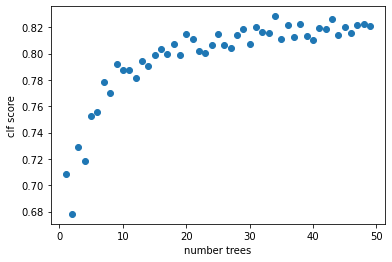

In [27]:
n_matrix = np.arange(1, 50, 1)

print(n_matrix.shape)

# intialize matrix to keep track of tree number and scores
forest_score_mat = np.zeros((n_matrix.shape[0],2))
print(forest_score_mat.shape)

k = 0
for k,n in enumerate(n_matrix):
    clf_this_forest = RandomForestClassifier(n_estimators=n)
    eval_this_forest = evaluate_classifer(clf_this_forest, x_train, y_train, x_test, y_test)
    
    forest_score_mat[k][0] = n
    forest_score_mat[k][1] = eval_this_forest['clf_score']
# print(forest_score_mat)

plt.figure()
plt.scatter(forest_score_mat[:,0],forest_score_mat[:,1])
plt.xlabel('number trees')
plt.ylabel('clf score')


plt.show()